## Introduction 
In this project, my goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4)

## Project Goals

+ Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

+ Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

+ Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

+ Run a pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

+ Estimate a bounding box for vehicles detected.

## Getting Started

+ `utils.py` contains utility helper functions including:
  
  + Compute HOG features & visualizations  
  + Compute binned color features
  + Compute color histogram features
  + Draw labeled boxes
  + Extract features from an image or a list of images
  + Search through a list of windows   
  + Add heat maps
  + Convert color from RGB to LUV & YCrCB
  
+ `Vehicle-Detection-Pipeline.ipynb` contains a pipeline to search and classify vehicles using a sliding window with support for false positive filtering. This pipeline applies to both images or a video.

## Data Set

The data consists of labeled images from [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself. Some example images for testing your pipeline on single frames are located in the test_images folder. Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier. 

Here's a quick preview of some of the images in the labeled data...

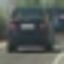

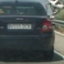

In [1]:
# For vehicles
from IPython.display import Image
from IPython.display import display
x = Image(filename='vehicles/GTI_Far/image0000.png') 
y = Image(filename='vehicles/GTI_MiddleClose/image0009.png') 
display(x, y)

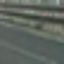

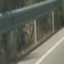

In [2]:
# For non-vehicles
from IPython.display import Image
from IPython.display import display
x = Image(filename='non-vehicles/GTI/image100.png') 
y = Image(filename='non-vehicles/GTI/image1002.png') 
display(x, y)

## Training Pipeline

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import re
import os
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from utils import *
from sklearn.model_selection import train_test_split
%matplotlib inline  

### Identify data directories

In [4]:
test_images = glob.glob('test_images/*')
output_directory = 'output_images/'
vehicle_images = glob.glob('vehicles/*/*')
non_vehicle_images = glob.glob('non-vehicles/*/*')
input_video = 'project_video.mp4' 
processed_project_video = 'processed_project_video.mp4'

### Define dictionary to store defaults

In [21]:
settings = dict()
settings['color_space'] = 'YCrCb' # HSV, LUV, HLS, YUV, YCrCb
settings['spatial_size'] = (32, 32) 
settings['hist_bins'] = 32
settings['orient'] = 9 
settings['pix_per_cell'] = 8
settings['cell_per_block'] = 2
settings['hog_channel'] = 0 # Can be 0, 1, 2 or 'ALL'
settings['spatial_feat'] = True
settings['hist_feat'] = True
settings['hog_feat'] = True

### 1) Extract HOG features from training images

Let's start by creating a random index to be used to select random vehicle and non-vehicle images from our training data...

In [6]:
# choose a random vehicle / non-vehicle indicies
vehicle_ind = np.random.randint(0, len(vehicle_images))
non_vehicle_ind = np.random.randint(0, len(non_vehicle_images))

vehicle_image = mpimg.imread(vehicle_images[vehicle_ind])
non_vehicle_image = mpimg.imread(non_vehicle_images[non_vehicle_ind])


Next I'll use the `single_img_features` function by passing the randomly selected vehicle and non vehicle images to see the original image along with the HOG transformed images side by side...

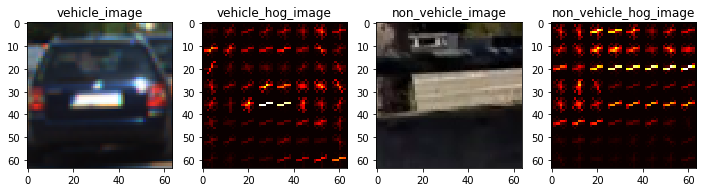

In [7]:
# extract features in a big list
vehicle_features, vehicle_hog_image = single_img_features(vehicle_image, 
                                    color_space=settings['color_space'], 
                                    spatial_size=settings['spatial_size'], 
                                    hist_bins=settings['hist_bins'], 
                                    orient=settings['orient'], 
                                    pix_per_cell=settings['pix_per_cell'], 
                                    cell_per_block=settings['cell_per_block'], 
                                    hog_channel=settings['hog_channel'], 
                                    spatial_feat=settings['spatial_feat'],
                                    hist_feat=settings['hist_feat'], 
                                    hog_feat=settings['hog_feat'],vis=True)
non_vehicle_features, non_vehicle_hog_image = single_img_features(non_vehicle_image, 
                                        color_space=settings['color_space'],
                                        spatial_size=settings['spatial_size'], 
                                        hist_bins=settings['hist_bins'],
                                        orient=settings['orient'], 
                                        pix_per_cell=settings['pix_per_cell'],
                                        cell_per_block=settings['cell_per_block'],
                                        hog_channel=settings['hog_channel'], 
                                        spatial_feat=settings['spatial_feat'],
                                        hist_feat=settings['hist_feat'], 
                                        hog_feat=settings['hog_feat'], vis=True)
images = [vehicle_image, vehicle_hog_image, non_vehicle_image, non_vehicle_hog_image]
titles = ['vehicle_image','vehicle_hog_image','non_vehicle_image','non_vehicle_hog_image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

### 2) Final choice of HOG Parameters

You can see the HOG transform shows the outline of the vehicle and the non-vehicle image structure. I experimented with different color spaces and different `skiimage.hog()` parameters (`orientations`, `hist_bins`, `spatial_size`, `pixes_per_cell` and `cells_per_block`) until I found the HOG transform outputs which resemble an outline of the image from our training set. For example, I noticed that `YCrCb` gives much better results than any of the other color spaces since the HOG transform identifies prominent features within the training images as seen above.

### 3) Training a classifier using selected HOG features

In order to train a classifier, I'll need to obtain features from our training data. Here are the vehicle and non-vehicle features...

In [8]:
vehicle_features = extract_features(vehicle_images, 
                                    color_space=settings['color_space'], 
                                    spatial_size=settings['spatial_size'], 
                                    hist_bins=settings['hist_bins'], 
                                    orient=settings['orient'], 
                                    pix_per_cell=settings['pix_per_cell'], 
                                    cell_per_block=settings['cell_per_block'], 
                                    hog_channel=settings['hog_channel'], 
                                    spatial_feat=settings['spatial_feat'],
                                    hist_feat=settings['hist_feat'], 
                                    hog_feat=settings['hog_feat'])
non_vehicle_features = extract_features(non_vehicle_images, 
                                        color_space=settings['color_space'],
                                        spatial_size=settings['spatial_size'], 
                                        hist_bins=settings['hist_bins'],
                                        orient=settings['orient'], 
                                        pix_per_cell=settings['pix_per_cell'],
                                        cell_per_block=settings['cell_per_block'],
                                        hog_channel=settings['hog_channel'], 
                                        spatial_feat=settings['spatial_feat'],
                                        hist_feat=settings['hist_feat'], 
                                        hog_feat=settings['hog_feat'])

Next I'll need to vertically stack the two sets of features to form the X matrix as needed by sklearn API as well as forming our target represented by vector y. Use StandardScaler to transform X matrix values to be normally distributed (e.g. Gaussian with 0 mean and unit variance). 

In [9]:
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

print("Number of vehicles: {}, non_vehicles: {} and shape {} ".format(len(vehicle_features), 
                                                                      len(non_vehicle_features), 
                                                                      len(y),
                                                                      X.shape))

Number of vehicles: 8792, non_vehicles: 8968 and shape 17760 


In [10]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

Train a Support Vector Classifier

In [11]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print('Feature vector length: ', len(X_train[0]))
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Feature vector length:  4932
15.19 Seconds to train SVC...
Test Accuracy of SVC =  0.9758


In [12]:
joblib.dump({'model': svc, 'settings': settings}, os.path.join(output_directory, 'svc.pkl'))

['output_images/svc.pkl']

## Sliding Window Search

The sliding window search window positions and scales were determined by iterating and looking at the outcome of the `visualize` function below until it met my expectations. For example, when I first started, I noticed a lot of false positives such as a box being drawn when there isn't a vehicle (nearby the top of trees). This led me to define a `y_start_stop` region from 400 to 656 inorder to localize the detection. Similarily, I experimented with various overlap regions from .25 to .75 but noticed that .6 yielded the better results.

As for color spaces, I tried RGB, HSV, LUV, HLS, YUV, YCrCb but finally settled with `YCrCb`. Similarily, for `hist_bins`, I tried 16, 32 and 64 but finally settled with 32.

In [13]:
overlap = 0.6
images = []
def vehicle_detection_pipeline(img):
    draw_image = np.copy(img)
    img = img.astype(np.float32)/255
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    y_start_stop = [400, 656] # Min and max in y to search in slide_window()
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(overlap, overlap))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=settings['color_space'], 
                            spatial_size=settings['spatial_size'], hist_bins=settings['hist_bins'], 
                            orient=settings['orient'], pix_per_cell=settings['pix_per_cell'], 
                            cell_per_block=settings['cell_per_block'], 
                            hog_channel=settings['hog_channel'], spatial_feat=settings['spatial_feat'], 
                            hist_feat=settings['hist_feat'], hog_feat=settings['hog_feat'])                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows),'windows')
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions:')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    return draw_img

0.4372670650482178 seconds to process one image searching 160 windows
0.4159231185913086 seconds to process one image searching 160 windows
0.41234707832336426 seconds to process one image searching 160 windows
0.4083380699157715 seconds to process one image searching 160 windows
0.4282870292663574 seconds to process one image searching 160 windows
0.4164309501647949 seconds to process one image searching 160 windows


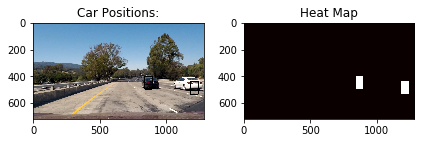

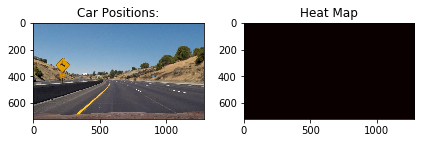

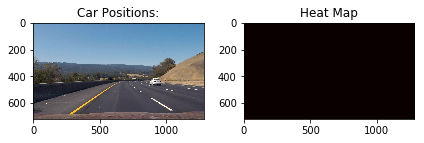

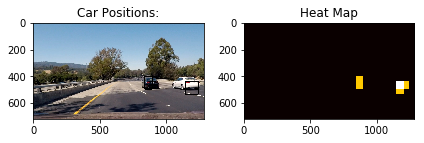

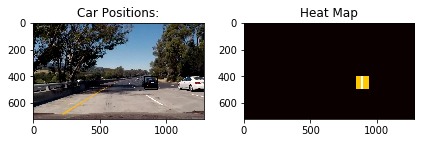

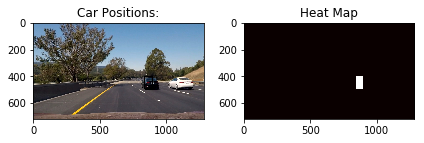

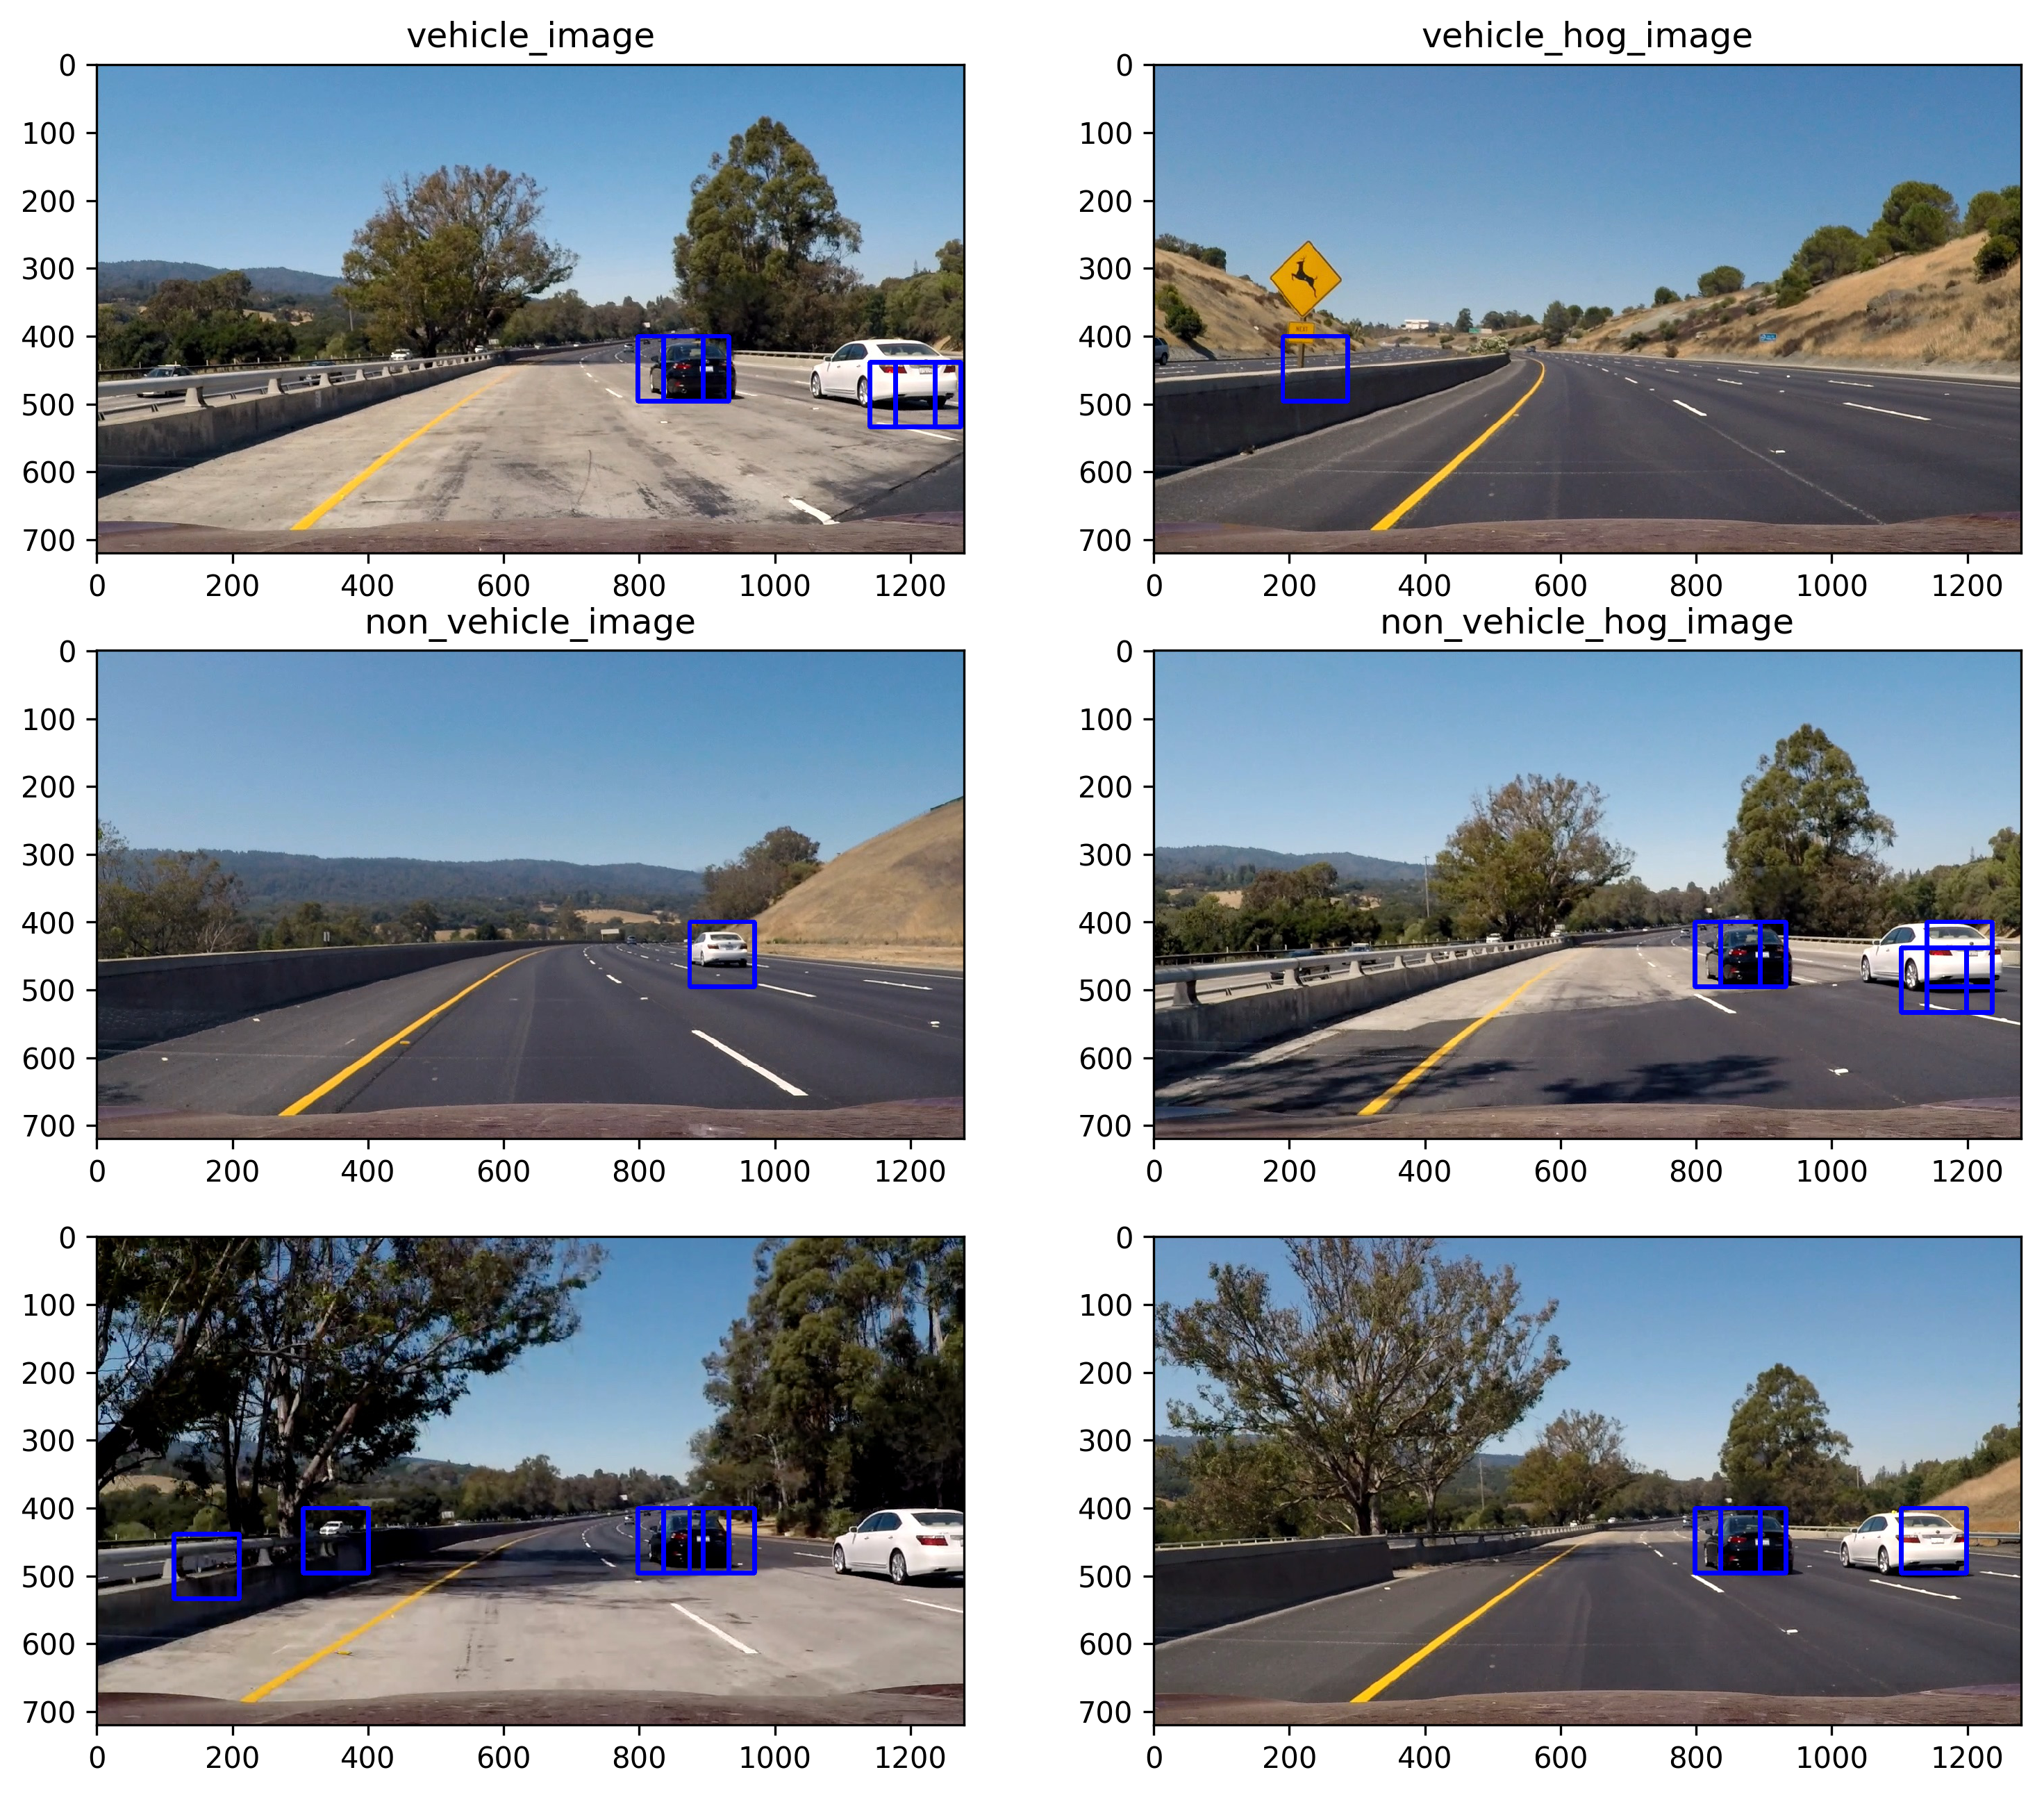

In [14]:
for file in test_images:
    t1 = time.time()
    vehicle_detection_pipeline(mpimg.imread(file))
#     bounding_boxes_image = vehicle_detection_pipeline(file)
#     image_name = os.path.split(file)[-1]
#     cv2.imwrite(os.path.join(output_directory, 'processed_'+ image_name), bounding_boxes_image)

fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)

In [15]:
windows = create_windows(overlap)

In [16]:
def process_image(image):
    # Save a raw image
    draw_image = np.copy(image)
    # Normalize image
    image = image.astype(np.float32)/255
    # Apply pipeline to the image to create black and white image
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=settings['color_space'], 
                            spatial_size=settings['spatial_size'], hist_bins=settings['hist_bins'], 
                            orient=settings['orient'], pix_per_cell=settings['pix_per_cell'], 
                            cell_per_block=settings['cell_per_block'], 
                            hog_channel=settings['hog_channel'], spatial_feat=settings['spatial_feat'], 
                            hist_feat=settings['hist_feat'], hog_feat=settings['hog_feat'])  
    return draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

## Run Video Pipeline

Run the pipeline on the provided video while creating a heat map of vehicle detections. 

In [17]:
clip1 = VideoFileClip(input_video)

In [18]:
output_video = clip1.fl_image(process_image)

In [19]:
output_video.write_videofile(processed_project_video, audio=False)

[MoviePy] >>>> Building video processed_project_video.mp4
[MoviePy] Writing video processed_project_video.mp4


100%|█████████▉| 1260/1261 [02:05<00:00, 10.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_project_video.mp4 



Here's a link to the [video](https://youtu.be/HY2zujnM-yY).

In [20]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(processed_project_video))

### Discussion

#### Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

This project required a lot of iterations to find the HOG parameters which help detect vehicles. Future improvements could be to increase training data size to reduce false positives, implement the heatmap over several frames, improve speed of classifier by using neural nets and integrate this project with lane detection. 